# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.core.callback import CallbackCollection, Callback
from pymoo.optimize import minimize
from pymoo.problems.dyn import TimeSimulation
from pymoo.problems.static import StaticProblem
from pymoo.problems.dynamic.df import DF1,DF2,DF3,DF4,DF5,DF6,DF7,DF8,DF9,DF10,DF11,DF12,DF13,DF14
from pymoo.indicators.igd import IGD

# Load Models and Data Test Train and (n_evals + reference_PF obtained from DNSGA2).

In [9]:
RNN = load_model('my_dataset/my_models/RNN_model_110.h5')
LSTM = load_model('my_dataset/my_models/LSTM_model_1.h5')
GRU = load_model('my_dataset/my_models/GRU_model_1.h5')

In [12]:
# Test using our Metrics.
path = 'my_dataset/X_and_y/'
data_test_train = np.load(path+'data_test_train_df10.npy', allow_pickle=True)

In [13]:
#
n_evals = np.load('my_dataset/n_evals/n_evals.npy', allow_pickle=True)
reference_PF = np.load('my_dataset/reference_PF/reference_PF.npy', allow_pickle=True)
#dnsga2_POFs_1_9 = np.load('my_dataset/obtained_PF/POFs_0_to_9.npy', allow_pickle=True)
#dnsga2_POFs_10_14 = np.load('my_dataset/obtained_PF/POFs_10_to_14.npy', allow_pickle=True)
my_df10 = pd.read_csv('my_dataset/PS/ps_DF_10.csv')

# Explore, Treat and Use Our Data.

In [14]:
data_test_train.shape, type(data_test_train)

((20, 2500, 10), numpy.ndarray)

In [15]:
%%time
RNN_POS = RNN.predict(data_test_train)
LSTM_POS = LSTM.predict(data_test_train)
GRU_POS = GRU.predict(data_test_train)

1/1 [==============================] - 1s 1s/step
Wall time: 6.65 s


In [16]:
RNN_POS.shape, LSTM_POS.shape, GRU_POS.shape

((20, 25000), (20, 25000), (20, 25000))

In [17]:
RNN_POS_reshaped = np.reshape(RNN_POS , (RNN_POS.shape[0], RNN_POS.shape[1]//10, 10))
print(RNN_POS_reshaped.shape)
RNN_POS_reshaped = np.reshape(RNN_POS_reshaped , (RNN_POS.shape[0]*5, RNN_POS.shape[1]//50, 10))
print(RNN_POS_reshaped.shape)

LSTM_POS_reshaped = np.reshape(LSTM_POS , (LSTM_POS.shape[0], LSTM_POS.shape[1]//10, 10))
print(LSTM_POS_reshaped.shape)
LSTM_POS_reshaped = np.reshape(LSTM_POS_reshaped , (LSTM_POS.shape[0]*5, LSTM_POS.shape[1]//50, 10))
print(LSTM_POS_reshaped.shape)

GRU_POS_reshaped = np.reshape(GRU_POS , (GRU_POS.shape[0], GRU_POS.shape[1]//10, 10))
print(GRU_POS_reshaped.shape)
GRU_POS_reshaped = np.reshape(GRU_POS_reshaped , (GRU_POS.shape[0]*5, GRU_POS.shape[1]//50, 10))
print(GRU_POS_reshaped.shape)

(20, 2500, 10)
(100, 500, 10)
(20, 2500, 10)
(100, 500, 10)
(20, 2500, 10)
(100, 500, 10)


In [18]:
# Examples
problem = DF1()
out = {}
problem._evaluate( np.array([[1,2,3,4,5,6,7,8,9,10]]),  out)
print(out["F"])

[[  1.         384.77424633]]


#  Our Model Convergence in DF10.

In [19]:
def plot_models_IGD(POS, model_name='RNN', isShow=True, problem = DF10(), isLine=True):
    #RNN_POS_reshaped

    pof_every_generation = []
    for i in range(POS.shape[0]):
        out = {}
        problem._evaluate( POS[i],  out)
        pof_every_generation.append(out["F"])
    pof_every_generation = np.array(pof_every_generation)    

    hist_F = pof_every_generation.copy()
    my_generations = np.arange(400,500, step=1)
    metric = IGD(reference_PF[9], zero_to_one=True)

    igd = [metric.do(_F) for _F in hist_F]
    #plt.plot(my_generations, igd,  color='black', lw=0.7, label="")
    plt.scatter(my_generations, igd,  facecolor="none", edgecolor='green', marker="p", label="Avg. CV of Pop "+model_name)
    #plt.plot(my_generations, reference_PF[9], color='red', lw=0.7, label="POF")
    if(isLine):
        plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
    title =  "Convergence_"+ model_name +"_Model_in_DF10"
    plt.title(title)
    plt.xlabel("Number of Generations")
    plt.savefig('my_dataset/performance/'+title+'.png')
    plt.ylabel("IGD")
    plt.yscale("log")
    plt.legend()
    if(isShow):
        plt.show()

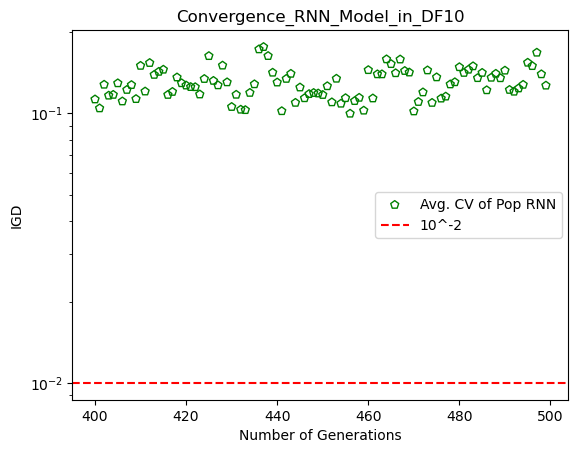

In [20]:
plot_models_IGD(RNN_POS_reshaped, model_name='RNN')

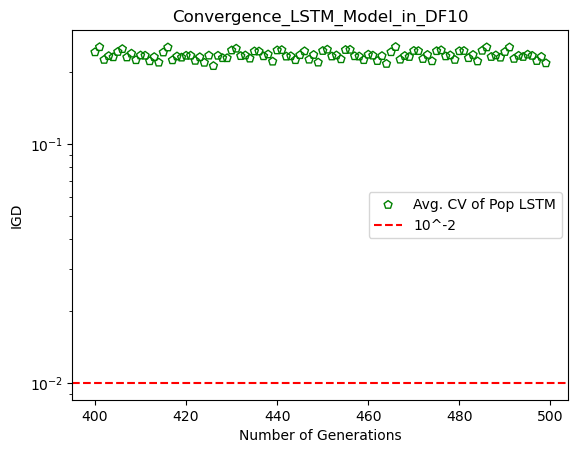

In [21]:
plot_models_IGD(LSTM_POS_reshaped, model_name='LSTM')

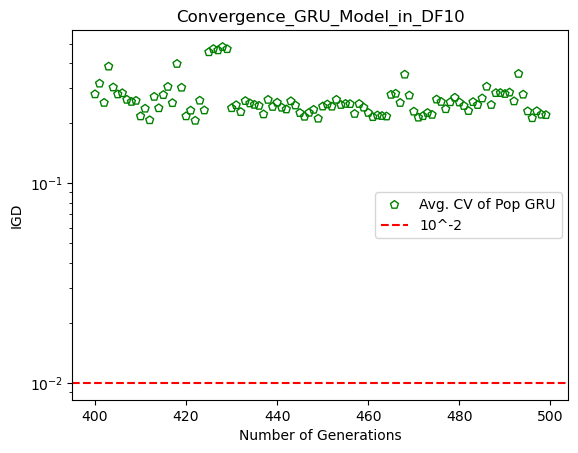

In [22]:
plot_models_IGD(GRU_POS_reshaped, model_name='GRU')

# DNSGA2 Convergence in DF10.

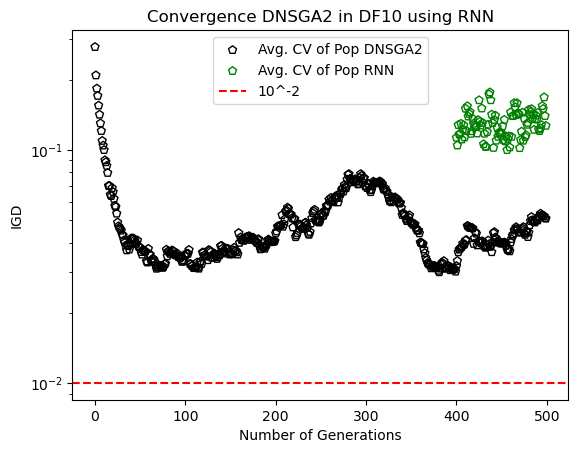

Wall time: 13.1 s


In [23]:
%%time
data = my_df10.copy()
new_df10 = []
for i in range(0,data.shape[0],500):
    new_df10.append(data[i:i+500])
new_df10 = np.array(new_df10)
# new_df10.shape --> (500 500 10)

problem = DF10()
pof_every_generation = []
for i in range(new_df10.shape[0]):
    out = {}
    problem._evaluate( new_df10[i],  out)
    pof_every_generation.append(out["F"])
pof_every_generation = np.array(pof_every_generation)    

hist_F = pof_every_generation.copy()
my_generations = np.arange(0,500, step=1)

metric = IGD(reference_PF[9], zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]
#plt.plot(my_generations, igd,  color='black', lw=0.7, label="")
plt.scatter(my_generations, igd,  facecolor="none", edgecolor='black', marker="p", label="Avg. CV of Pop DNSGA2")
#plot_IGD(LSTM_POS_reshaped,isShow=False)
plot_models_IGD(RNN_POS_reshaped, model_name='RNN', isShow=False, isLine=False)
#plt.plot(my_generations, reference_PF[9], color='red', lw=0.7, label="POF")

plt.xlabel("Number of Generations")
plt.savefig('my_dataset/performance/Convergence_DNSGA2_in_DF10_using_RNN.png')
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence DNSGA2 in DF10 using RNN")
plt.xlabel("Number of Generations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()